In [216]:
# On importe les librairies utilisées plus tard

import matplotlib.pyplot as plt
import os
import random
import numpy as np
import cv2
from scipy.cluster.vq import kmeans,vq
# On lis le dossier contenant les images pour entrainer notre IA

train_path="../../dataset/training_set"
class_names=os.listdir(train_path)

print(class_names) # ==> ['dogs', 'cats']

image_paths=[]
image_classes=[]

['cats', 'dogs']


In [197]:
# dans ce bloc apparaîtron toutes les fonctions

# Fonction pour retourner le chemin de toutes les images avec un dossier
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

# Fonction pour tracer les pointsclés 
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

In [198]:
for training_name in class_names:
    dir_= os.path.join(train_path,training_name)
    class_path = img_list(dir_)
    image_paths += class_path

In [199]:
#print(image_paths) la liste contient le chemin de toutes les images de chien et de chat
print(len(image_paths))

8000


In [200]:
image_classes_dog=[0]*(len(image_paths)//2) # on crée tableau contenant des 0 (chien) de 4000 éléments (on a 8000 images, soit la moitié)

image_classes_cat=[1]*(len(image_paths)//2) # on crée tableau contenant des 1 (chat) de 4000 éléments (on a 8000 images, soit la moitié)

image_classes=image_classes_dog+image_classes_cat # on concatène les tableaux pour avoir nos 220 éléments



In [201]:
# print(image_classes) liste de 4000 0 suivis de 4000 1

In [202]:
dataset_template=[]

for i in range(len(image_paths)):
    dataset_template.append((image_paths[i],image_classes[i])) # on associe le chemin de l'image à son animal (1 pour chat, 0 pour chien)

In [203]:
print(dataset_template[0]) # cat1 , 0
print(dataset_template[3999]) # cat999 , 0
print(dataset_template[4000]) # dog1 , 1
print(dataset_template[7999]) # dog999 , 1

('../../dataset/training_set\\cats\\cat.1.jpg', 0)
('../../dataset/training_set\\cats\\cat.999.jpg', 0)
('../../dataset/training_set\\dogs\\dog.1.jpg', 1)
('../../dataset/training_set\\dogs\\dog.999.jpg', 1)


In [210]:
dataset = dataset_template
random.shuffle(dataset) # on mélange aléatoirement notre dataset
train = dataset[:6000] # on s'entraine 6000 éléments
test = dataset[6000:] # on va tester sur les 2000 autres

In [211]:
print(train[1])

('../../dataset/training_set\\dogs\\dog.1329.jpg', 1)


In [212]:
image_paths_train, y_train = zip(*train) # = for i in range(len(train)) train[i][0] , train[i][1] pour chaque tuple dans la liste, on met les éléments dans deux listes distinct
image_paths_test, y_test = zip(*test) # = for i in range(len(test)) test[i][0] , test[i][1]

In [295]:
print(len(image_paths_train))

6000


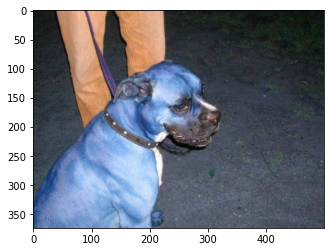

In [298]:
orb=cv2.ORB_create() # on créé l'orb, qui va permettre de détourer les animaux sur les images grâces aux couleurs

im=cv2.imread(image_paths_train[1]) # on affiche une image avec matplotlib pour tester

plt.imshow(im) # ==> <matplotlib.image.AxesImage at >

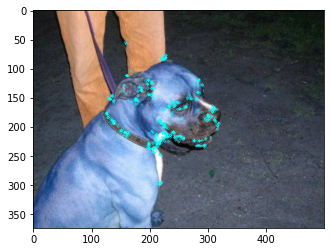

In [214]:
# On trace les points autour de l'image precedemment testé
            
kp = orb.detect(im,None)
kp, des = orb.compute(im, kp)
img= draw_keypoints(im,kp)

In [302]:
# On ajoutes les descriptors des images d'entrainement dans une liste
descri_list = []
counter = 0
for path in image_paths_train:
    im=cv2.imread(path)
    kp=orb.detect(im,None)
    keypoints,descriptor = orb.compute(im, kp)
    if str(type(descriptor)) != "<class 'NoneType'>": # certains descriptor sont null et cela provoque des erreurs avec la concatenation plus tard
        descri_list.append((path,descriptor))
    else:
        counter += 1
    

In [305]:
print(f"Nombre de descriptor NoneType: {counter}")
print(f"Longueur descriptor liste: {len(descri_list)}")

Nombre de descriptor NoneType: 7
Longueur descriptor liste: 5993


In [325]:
descriptors = descri_list[0][1]
print(f"premier discriptor {descriptors}")
print(f"taille {len(descriptors)}")
counter2 = 0

for image_path,descriptor in descri_list[1:]:
    counter2 += 1
    np.vstack((descriptors,descriptor))
    
print(f"element parcouru: {counter2}")
print(f"taille de descriptors {np.shape(descriptors)}")
descriptors.shape 


descriptors_float=descriptors.astype(float)

premier discriptor [[ 35  91 123 ... 140   7 251]
 [ 35  98  34 ...  15  59 207]
 [ 27  81 106 ... 142 117 118]
 ...
 [  2 184 155 ...  64  47 250]
 [ 75  20 181 ... 204  25 125]
 [  8 149  63 ... 192 165 251]]
taille 500
element parcouru: 5992
taille de descriptors (500, 32)


In [326]:
# Utilisation du Kmeans

k=200
voc, variance= kmeans(descriptors_float, k, 1)

In [327]:
# Creation de l'histogramme des images d'entrainement

im_features = np.zeros((len(image_paths),k),"float32")


for i in range(len(descri_list)):
    animals, distance =vq(descri_list[i][1], voc)
    for elt in animals:
        im_features[i][elt]+=1